# Simulate Spectral Rotation
Evaluate interaction with band power measures

## Set-up

### Imports

In [1]:
# ! pip install neurodsp

In [2]:
# Imports - standard
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neurodsp.spectral import rotate_powerlaw
from specparam.sim import sim_power_spectrum

In [3]:
# Imports - custom
import sys
sys.path.append(f"../code")
from paths import PROJECT_PATH
from settings import BANDS, BCOLORS
from specparam_utils import compute_band_power

In [4]:
# auto reload
%load_ext autoreload
%autoreload 2

### Settings

In [5]:
# set plotting style
plt.style.use("../mplstyle/default.mplstyle")

# set/create figure directory
dir_output = f"{PROJECT_PATH}/figures/supporting_figures"
if not os.path.exists(dir_output):
    os.makedirs(dir_output)


### Functions

In [6]:
def run_simulation(f_rotation, delta_exponent=1, aperiodic_params=[10, 2],
                    f_range=[4, 100]):
    

    # simulate power spectrum and rotate
    freqs, psd_pre = sim_power_spectrum(f_range, aperiodic_params, [])
    psd_post = rotate_powerlaw(freqs, psd_pre, delta_exponent, f_rotation)
    spectra = np.vstack([psd_pre, psd_post])

    # compute band power
    df_list = []
    for band, f_range in BANDS.items():
        power = compute_band_power(freqs, spectra, f_range, method='mean', log_power=True)
        for i_epoch, epoch in enumerate(['pre', 'post']):
            df_i = pd.DataFrame({'epoch': epoch, 'band': band, 
                                'power': power[i_epoch]}, index=[0])
            df_list.append(df_i)
    df = pd.concat(df_list, axis=0)

    # compute change in power
    results = df.pivot(index='band', columns='epoch', values='power').reset_index()
    results['diff'] = results['post'] - results['pre']

    return results



## Main

### simulate example spectral rotation

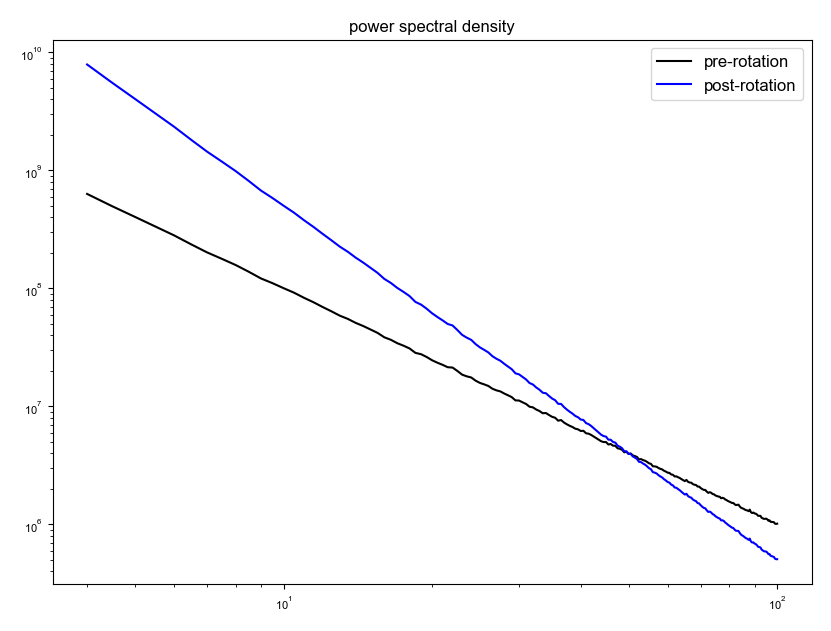

epoch,band,post,pre,diff
0,alpha,113.404401,104.215740,9.188661
1,gamma,500.729526,512.062494,-11.332968


In [7]:
# simulate example spectral rotation

# rotation params
delta_exponent = 1
f_rotation = 50

# original spectrum params
aperiodic_params = [10, 2]
f_range = [4, 100] 

# simulate time-series and comp PSD- for pre-treatment condition
freqs, psd_pre = sim_power_spectrum(f_range, aperiodic_params, [])
psd_post = rotate_powerlaw(freqs, psd_pre, delta_exponent, f_rotation)
spectra = np.vstack([psd_pre, psd_post])

# compute band power
df_list = []
for band, f_range in BANDS.items():
    power = compute_band_power(freqs, spectra, f_range, method='sum', log_power=True)
    for i_epoch, epoch in enumerate(['pre', 'post']):
        df_i = pd.DataFrame({'epoch': epoch, 'band': band, 
                            'power': power[i_epoch]}, index=[0])
        df_list.append(df_i)
df = pd.concat(df_list, axis=0)

# compute change in power
results = df.pivot(index='band', columns='epoch', values='power').reset_index()
results['diff'] = results['post'] - results['pre']

# plot
fig, ax = plt.subplots(figsize=[8,6])
ax.plot(freqs, psd_pre, color='k', label='pre-rotation')
ax.plot(freqs, psd_post, color='b', label='post-rotation')
ax.set_xscale('log'), ax.set_yscale('log')
plt.legend(fontsize=12)
plt.title('power spectral density')
plt.show()

results


In [8]:
# run simulation with different rotation frequencies

f_rotations = np.arange(5, 105, 5)

# run simulation
dfs = []
for f_rotation in f_rotations:
    df = run_simulation(f_rotation)
    df['f_rotation'] = f_rotation
    dfs.append(df)
results = pd.concat(dfs, axis=0, ignore_index=True)

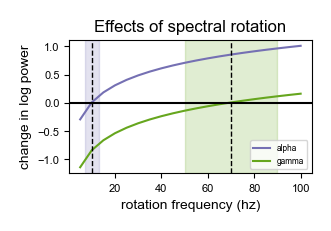

In [11]:
# plot results

# plot change in power v rotation frequency
fig, ax = plt.subplots(figsize=[3,2])
for band, _ in BANDS.items():
    df = results.loc[results['band']==band]
    df.plot(x='f_rotation', y='diff', ax=ax, color=BCOLORS[band])

# label plot
ax.set_title('Effects of spectral rotation')
ax.set(xlabel='rotation frequency (hz)', ylabel='change in log power')
ax.axhline(0, color='k')
handles, labels = ax.get_legend_handles_labels()
labels = [band for band, _ in BANDS.items()]
ax.legend(handles, labels)

# annotate each bands
for band, f_range in BANDS.items():
    # shade band
    ax.axvspan(f_range[0], f_range[1], color=BCOLORS[band], alpha=0.2)

    # mark center
    ax.axvline(np.mean(f_range), linestyle='--', color='k', linewidth=1)

# save/show
plt.savefig(f"{dir_output}/sim_spectral_rotation.png")
plt.show()
